 ## Jordan Gittleman - EECE7150 - HW1

2(b)  Write up a general purpose simulator for the state transition matrix

My weather sequence simulator consists of two main parts, the sequencer using the given state transition function, and a normalized counter to return the proability distribution of the resulting weather sequence

In [55]:
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt

In [56]:
def weather_sim(n,today = False,repeat = False, display = True):
    # takes in n number of days in sequence, today input if a starting day is desired,
    # a repeat boolean to check the probabilities for a single weather state day,
    #  and display boolean to print distribution data
    if today == False:
        # randomly select a weather state for today if one is not specified
        today = np.random.choice(["sunny", "cloudy", "rainy"]) # originally had this as default argument but numpy seems to get stuck when doing that
    # using a dict object for efficent grabbing
    choices = {"sunny":[.8, .2, 0], "cloudy":[.4, .4, .2], "rainy":[.2, .6, .2]}
    count = [today]
    for i in range(n-1):
        # choose tomorrow's weather with weighted random choice from dictionary corresponding to today
        tomorrow =  np.random.choice(list(choices.keys()),p=choices[today])
        # store day's in an output list
        count.append(tomorrow)
        if not(repeat):
            today = tomorrow
    return normalized_count(count,display), count

In [57]:
def normalized_count(val,display):
    # takes in sequence of days and display boolean
    # returns normalized count and optional print

    # use counter object to tally amount of weather states in a sequence
    normCount = Counter(val)
    # normalize counter values for probability (must sum to 1)
    total = sum(normCount.values())
    for key in normCount:
        normCount[key] /= total
    if display:
        print("first day is: " + val[0])
        print("total runs: " + str(total))
        print("sunny: " +str(normCount['sunny']))
        print("cloudy: " +str(normCount['cloudy']))
        print("rainy: " +str(normCount['rainy']))
        print("~~~~~")
    return normCount

quickly testing these functions, it becomes clear as the number of itterations increasing corresponds to the stationary distribution given in the solutions found here: https://github.com/pptacher/probabilistic_robotics/blob/master/ch2_recursive_state_estimation/ch2_recursive_state_estimation.pdf

In [58]:
weather_sim(10)
weather_sim(100)
weather_sim(1000)
weather_sim(10000)
print("~")



first day is: cloudy
total runs: 10
sunny: 0.5
cloudy: 0.3
rainy: 0.2
~~~~~
first day is: sunny
total runs: 100
sunny: 0.69
cloudy: 0.25
rainy: 0.06
~~~~~
first day is: rainy
total runs: 1000
sunny: 0.641
cloudy: 0.297
rainy: 0.062
~~~~~
first day is: cloudy
total runs: 10000
sunny: 0.6349
cloudy: 0.2964
rainy: 0.0687
~~~~~
~


(c) Use your simulator to determine the stationary distribution of this Markov chain. In particular I would like everyone to address
(i) How you initialize the simulation
(ii) How many transitions you consider before taking a result and
(iii) How many simulation runs you conducted to arrive at the statistics for the stationary distribution.

## Answering the above questions:
(i) the simulation is initialized by randomly seelcting a starting day if one is not specified. \
(ii) in this section, I create a weather sequence and graph the probailities of the given weather states along with the given stationary values from literature. Once the states fall within a small consistent range of the given values, I consider that range to be a reasonable convergence estimate \
(iii) while i take 100000 values to arrive at my statistic, This is much larger than is actually needed upon examination of the below graphs, a more conservative number can lie around ~2000 days

## How this code works

Originally, I had re-ran my sequencer with increasing sequence lengths and collected the stationary distributions. This original strategy, however, resulted in an extremely slow run time, since a 10000 day sequence can take almost 3 second to compute and return a value, this technique is incredibly slow if I want to find high resolution data. \
 (which I do :D)

To optimize graphing for a large sequence, I computer one 10000 day sequence and seperately calculated the stationary distribution from an expanding window of days, this allowed me to find and graph convergence without re-sequencing every time.

In [59]:
weatherData = {"sunny":[], "cloudy":[], "rainy":[]}
window = {"sunny":[], "cloudy":[], "rainy":[]}
# calculate a single 10000 day weather sequence
[norm,weather] = weather_sim(10000, display = False)

# incrementally increase a window size to grab stationary distribution one and store values 
# in a dict of lists
for i in range(1,10000,1):
    window = normalized_count(weather[0:i],display = False)
    for key in weatherData.keys():
        weatherData[key].append(window[key])
    
    

In [60]:
# stationary distribution from literature
stationary = {"sunny":9/14,"cloudy":2/7,"rainy":1/14}

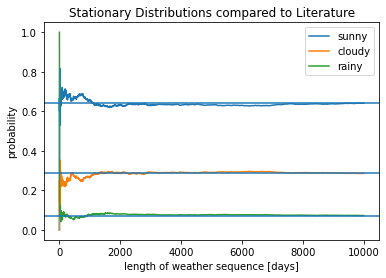

In [61]:
# plotting the weather data alongside values from literature
for key in weatherData.keys():
    plt.plot(weatherData[key])
for key in stationary.keys():
    plt.axhline(stationary[key])
plt.title("Stationary Distributions compared to Literature")
plt.xlabel("length of weather sequence [days]")
plt.ylabel("probability")
plt.legend(weatherData.keys())
plt.show()

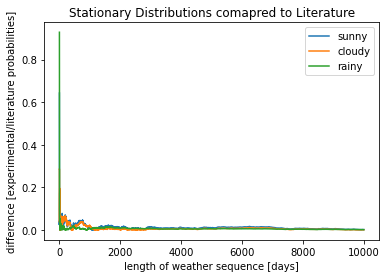

In [62]:
# Plotting again but as a difference from the literature values for fun
for key in weatherData.keys():
    plt.plot(abs(np.array(weatherData[key])-stationary[key]))
plt.legend(weatherData.keys())
plt.title("Stationary Distributions comapred to Literature")
plt.xlabel("length of weather sequence [days]")
plt.ylabel("difference [experimental/literature probabilities]")
plt.show()

(d) The solution is derived via a closed analytical form. Can you do the diagonalization of the state matrix A with python to come up with the same result.

## Solution

to get the steady state values of our stochastic row matrix A, we can leverage the condition that the steady state matrix = stochastic matrix * steady state matrix

This setup mirrors that of how eigenvectors/values work in that:
eigenvalue*eigenvector = matrix * eigenvector, this relationship works assuming the matrix is grouped by columns and the eigenvalue used is = 1, thus preserving the relationship that the steady state matrix must not be changed by left muliplying our stochastic

thus, we can transpose our stochastic matrix, find the egeinverctors/values, get the corresponding vector for the eigenvalue = 1, and normalize it to get our stationary distribution

In [63]:
# taking state matrix a from the problem statement
a = np.array([[.8, .2, 0], [.4, .4, .2], [.2, .6, .2]])
# transposing...
A = a.transpose()

# egeinvector column matrix, these can both be found easily with numpy...

vals, vects = np.linalg.eig(A) # outputs a tuple with pos 0 = values, and 1 = vectors

# pull out index of eigenvalue close to 1

value = np.isclose(vals,1)

# grab the corresponding eigenvector

distrib = vects[:,value]

# normalize so total probability = 1

distrib =  distrib/ sum(distrib)

print("stationary distribution:\n"+str(distrib)+'\n')

# diagonalize for fun and becuase the prompt asked

print("diagonalized stationary distribution:\n"+str(distrib*np.eye(3))+'\n')

print("given stationary distribution from literature:\n"+str(stationary)+'\n')

# this also matches reasonably with the experimentally found distribution from earlier...

print("stationary distribution from experimentation:\n"+str(norm))


stationary distribution:
[[0.64285714]
 [0.28571429]
 [0.07142857]]

diagonalized stationary distribution:
[[0.64285714 0.         0.        ]
 [0.         0.28571429 0.        ]
 [0.         0.         0.07142857]]

given stationary distribution from literature:
{'sunny': 0.6428571428571429, 'cloudy': 0.2857142857142857, 'rainy': 0.07142857142857142}

stationary distribution from experimentation:
Counter({'sunny': 0.6412, 'cloudy': 0.2862, 'rainy': 0.0726})
